# Exploration of Non Text Features 



In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
%matplotlib inline

# plotting magic

sns.set_style("darkgrid")

from pylab import rcParams
import matplotlib.pylab as plt
rcParams['figure.figsize'] = 14, 5

In [3]:
from dao import DataAccess

df = DataAccess.as_dataframe()

ImportError: No module named 'dao'

In [6]:
# Create a series that converts the `created_at` column into
# timeseries index, errors=1 amd coerse=1 since there are some errors in our data...
tm = pd.to_datetime(df.created_at)

In [29]:
df["alcohol"] = df["labels"].apply(lambda _:_["alcohol"])

In [30]:
df["time"] = tm                              # set time to the timeseries
df = df[~tm.isnull()]                        # remove NaT columns
dt = df.set_index("time")                    # set the TimeSeries index
dt["dayofweek"] = dt.index.dayofweek         # set day of week
dt["hourofday"] = dt.index.hour              # set hour of day

# Helpers and Plotters

In [31]:
def interval_sum(a, b):
    return lambda x: np.sum((a < x) & (x < b))

In [32]:
def groupby(table, key, predict_thres=.7):
    gb = table.groupby(key).agg({
        "user":len,
        "alcohol": np.sum
    })
    print(gb.columns)
    gb.columns = ["Drinking Tweets", "All Tweets"]
    gb["Drinking Tweets"] /= gb["Drinking Tweets"].sum()
    gb["All Tweets"] /= gb["All Tweets"].sum()
    return gb

def plot_groupby(gb, title, diff=False, kind="bar", **kwargs):
    ax = ((gb["Drinking Tweets"] - gb["All Tweets"]) if diff else gb).plot(
            title=title,
            kind=kind,
            **kwargs
        )
    return ax

## Day of Week as a Predictor


In [33]:
dayofweek = groupby(dt, "dayofweek")

Index(['alcohol', 'user'], dtype='object')


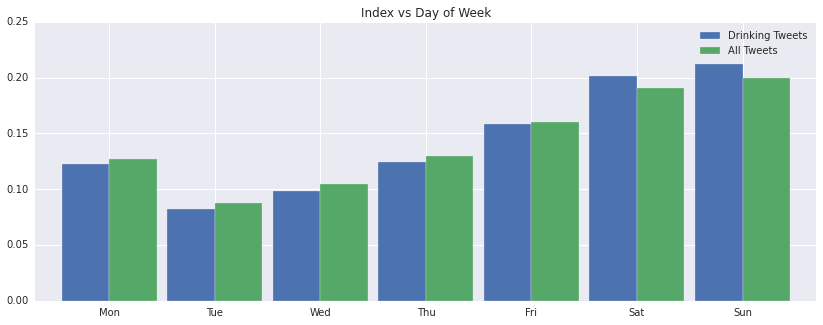

In [34]:
ax = plot_groupby(dayofweek, "Index vs Day of Week", width=.9)
ax.set_xticklabels(
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    rotation=0)
ax.set_xlabel("")
ax

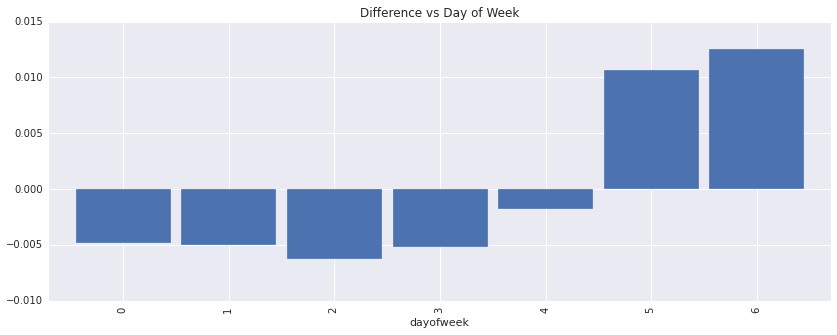

In [35]:
plot_groupby(dayofweek, "Difference vs Day of Week", diff=1, width=.9)

## Time of Day as a predictor

In [36]:
hourofday = groupby(dt, "hourofday")

Index(['alcohol', 'user'], dtype='object')


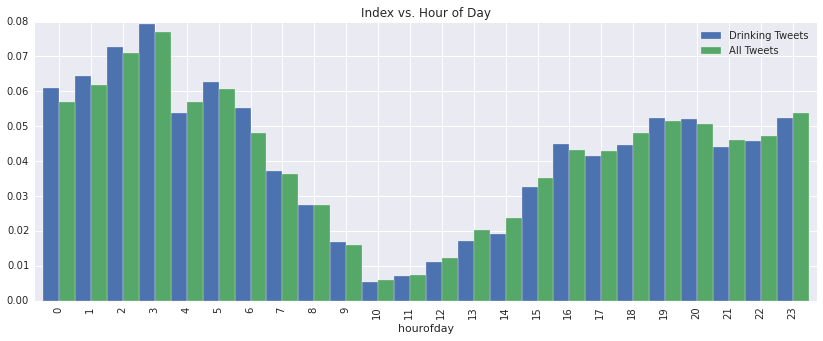

In [37]:
plot_groupby(hourofday, "Index vs. Hour of Day", width=1)

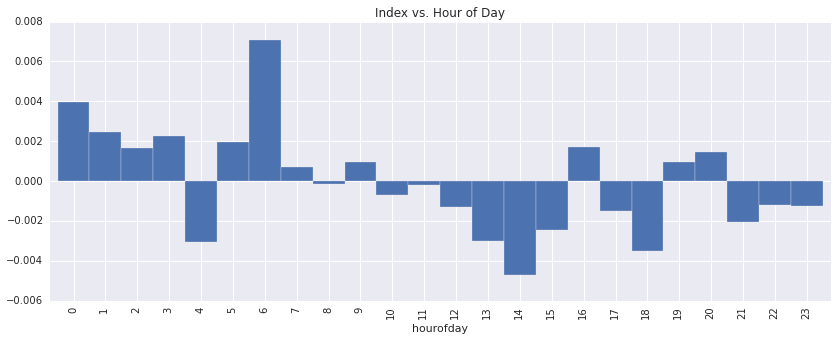

In [38]:
plot_groupby(hourofday, "Index vs. Hour of Day", diff=1, width=1)

## Day of Week*Time of Day as a Predictor

In [39]:
from itertools import product
dayhour = groupby(dt, ["dayofweek", "hourofday"])

xt  = list(range(0, 7*24))[::12]
xtl = list(
        map(", ".join,
             product(
                ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
                map(str, range(0, 24)))))[::12]

Index(['alcohol', 'user'], dtype='object')


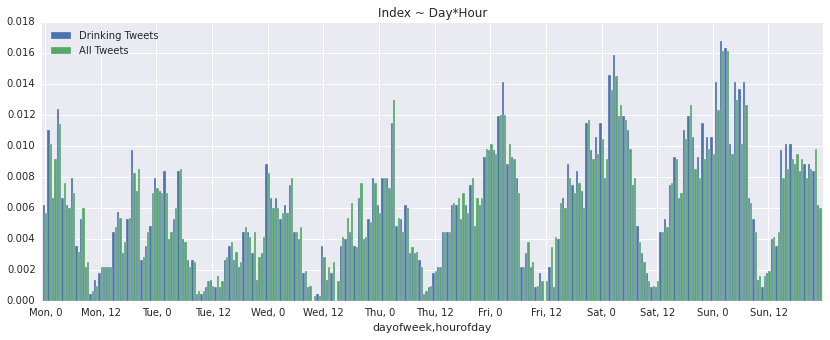

In [40]:
ax = plot_groupby(dayhour, "Index ~ Day*Hour", kind="bar", width=1)
ax.set_xticks(xt)
ax.set_xticklabels(xtl, rotation=0)
print()

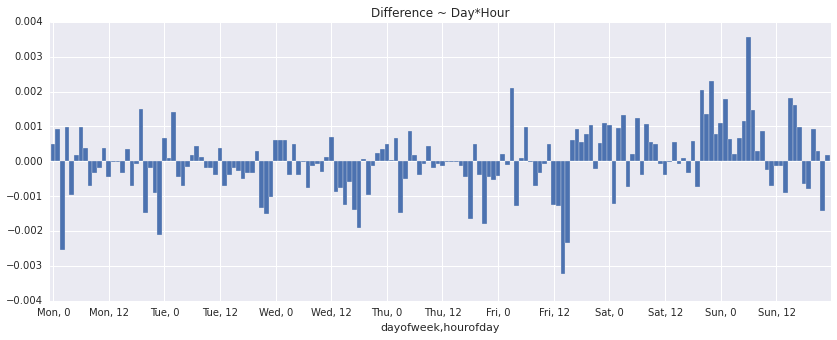

In [41]:
from itertools import product

ax = plot_groupby(dayhour, "Difference ~ Day*Hour", kind="bar", diff=1, width=1)
ax.set_xticks(xt)
ax.set_xticklabels(xtl, rotation=0)
print()

# User Graph Metrics as a Predictor

In [42]:
# Currently the user table is just a string, so we need to eval it and turn it into a table
lst = dt.set_index("predict").user.apply(str).apply(eval)
users = ~(lst.apply(type) == float)
t = lst[users]
du = pd.DataFrame.from_records(list(t), index=t.index)
du["predict"] = du.index
du["alcohol"] = (du.predict > 0.55).apply(int)
du.index = range(len(du))

In [43]:
du["normality"] = du.friends_count / (du.followers_count + du.friends_count + 1)
du["range"] = np.abs(du.followers_count - du.friends_count)
du["pop"] = (np.log(du.followers_count+1)) - np.log(du.friends_count+1)
du["harm"] = (du.followers_count + du.friends_count) / (1/(du.friends_count+1) + 1/(du.followers_count+1))

In [44]:
du_norm = du[
    ['favourites_count',
     'followers_count',
     'friends_count',
     'statuses_count',
     'normality',
     'range',
     'predict',
     'pop',
     'harm']
]

In [45]:
def density_plot(key, thres_range, log=False):
    d = du_norm[key] if not log else np.log(du_norm[key])
    for thres in thres_range:
        sns.kdeplot(d[du_norm.predict > (thres/100)], label="Alcohol@{}".format(thres), alpha=.4)
    ax = sns.kdeplot(d, label="Everything", color="red")
    plt.title("{} {} Density".format("Log"*log, key.title()))
    ax.set_yticks([])
    ax.set_xticks([])
    return ax

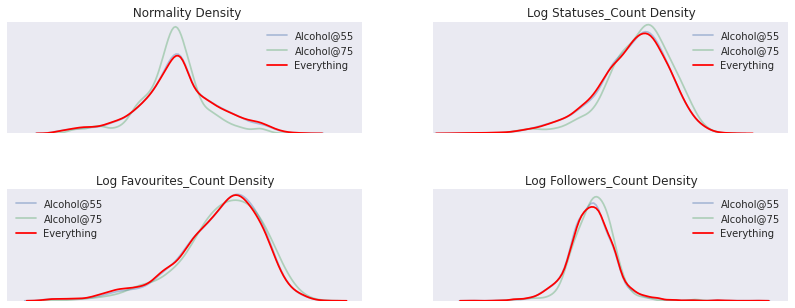

In [46]:
r = range(55, 95, 20)
plt.subplot(221), density_plot("normality", r, log=0)
plt.subplot(222), density_plot("statuses_count", r, log=1)
plt.subplot(223), density_plot("favourites_count", r, log=1)
plt.subplot(224), density_plot("followers_count", r, log=1)
print()

# User Create Time as a Predictor

In [47]:
du["time"] = pd.to_datetime(du["created_at"], coerce=1, errors=1)

In [48]:
du["days_old"] = pd.to_datetime("2015-6-5") - du.time

In [49]:
days = du["days_old"].apply(int) // 6.048e14

In [50]:
du_norm.statuses_count /= days
du_norm.favourites_count /= days
du_norm.followers_count /= days
du_norm.friends_count /= days

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/generic.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [51]:
du_norm.normality /= days

In [52]:
du_norm["days"] = days

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


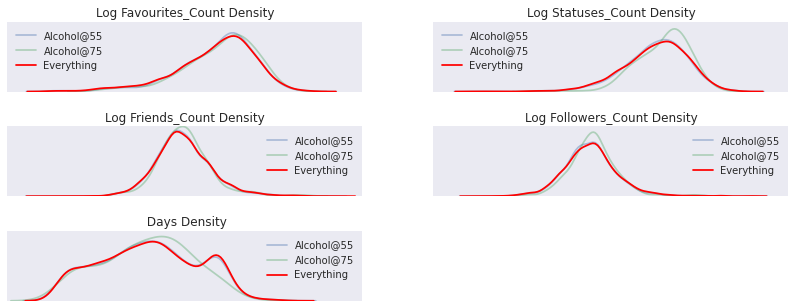

In [53]:
r = range(55, 95, 20)
plt.subplot(321), density_plot("favourites_count", r, log=1)
plt.subplot(322), density_plot("statuses_count", r, log=1)
plt.subplot(323), density_plot("friends_count", r, log=1)
plt.subplot(324), density_plot("followers_count", r, log=1)
plt.subplot(325), density_plot("days", r, log=0)
print()